In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
from datetime import datetime, timedelta

In [ ]:
start = datetime(2015, 1, 1)
end = datetime(2019, 1, 1)
# Fetch data using yfinance
df = yf.download('AAPL', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402168,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714720,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716955,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049524,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973553,237458000
...,...,...,...,...,...,...
2018-12-24,37.037498,37.887501,36.647499,36.707500,35.139702,148676800
2018-12-26,37.075001,39.307499,36.680000,39.292500,37.614292,234330000
2018-12-27,38.959999,39.192501,37.517502,39.037498,37.370171,212468400


In [ ]:
#df = df['Close'].resample('W').mean()
#set index for pycaret modelling
#df.set_index('Date', inplace=True)
df = df['Close']
df = df.asfreq('D')
df = df.interpolate()
df2 = df.copy()
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1460 entries, 2015-01-02 to 2018-12-31
Freq: D
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1460 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


In [ ]:
df

,Close
Date,
2015-01-02,27.332500
2015-01-03,27.075834
2015-01-04,26.819167
2015-01-05,26.562500
2015-01-06,26.565001
...,...
2018-12-27,39.037498
2018-12-28,39.057499
2018-12-29,39.183333


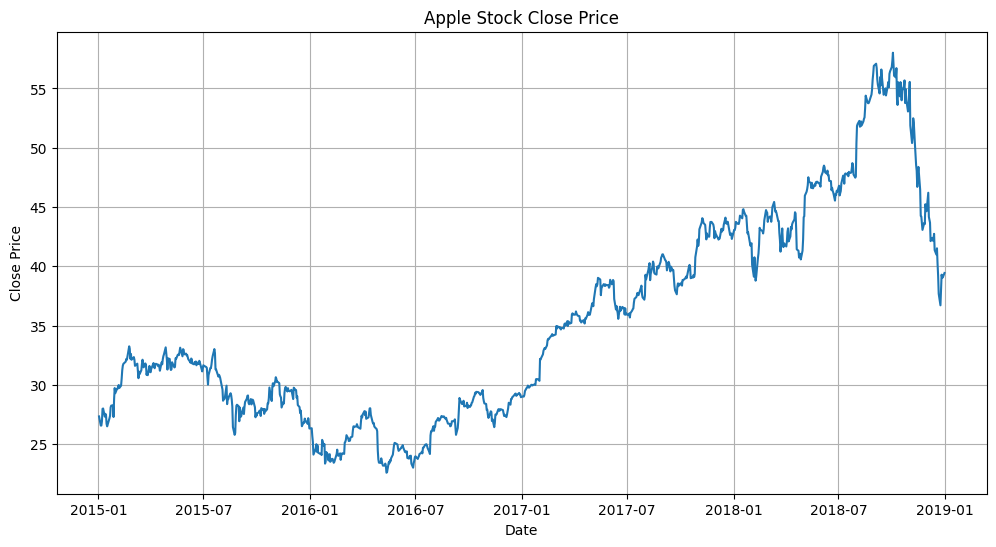

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df)
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import shapiro

def test_white_noise(series):
    # Ljung-Box test for white noise
    result = sm.stats.acorr_ljungbox(series, lags=[10], return_df=True)
    return result

def test_stationarity(series):
    # Use ADF and KPSS tests for stationarity
    adf_result = adfuller(series)
    kpss_result, p_value, lags, critical_values = kpss(series, regression='c')
    return adf_result, kpss_result

def test_adf(series):
    # Augmented Dickey-Fuller test
    result = adfuller(series)
    return result

def test_kpss(series):
    # Kwiatkowski-Phillips-Schmidt-Shin test
    result = kpss(series, regression='c')
    return result

def test_normality(series):
    # Shapiro-Wilk test for normality
    result = shapiro(series)
    return result

def run_all_tests(series):
    white_noise_result = test_white_noise(series)
    stationarity_adf_result, stationarity_kpss_result = test_stationarity(series)
    adf_result = test_adf(series)
    kpss_result = test_kpss(series)
    normality_result = test_normality(series)

    return {
        'White Noise Test': white_noise_result,
        'ADF Stationarity Test': adf_result,
        'KPSS Stationarity Test': kpss_result,
        'Normality Test': normality_result,
    }

def explain_results(results):
    explanations = {}

    # White Noise Test Explanation
    white_noise_result = results['White Noise Test']
    explanations['White Noise Test'] = (
        "Hypothesis: \n"
        "H0: The series is white noise.\n"
        "H1: The series is not white noise.\n"
        f"p-value: {white_noise_result['lb_pvalue'].iloc[0]}\n"
        f"Reject H0: {white_noise_result['lb_pvalue'].iloc[0] < 0.05}\n"
    )

    # ADF Stationarity Test Explanation
    adf_result = results['ADF Stationarity Test']
    explanations['ADF Stationarity Test'] = (
        "Hypothesis: \n"
        "H0: The series has a unit root (non-stationary).\n"
        "H1: The series is stationary.\n"
        f"ADF Statistic: {adf_result[0]}\n"
        f"p-value: {adf_result[1]}\n"
        f"Critical Values: {adf_result[4]}\n"
        f"Reject H0: {adf_result[1] < 0.05}\n"
    )

    # KPSS Stationarity Test Explanation
    kpss_result = results['KPSS Stationarity Test']
    explanations['KPSS Stationarity Test'] = (
        "Hypothesis: \n"
        "H0: The series is stationary.\n"
        "H1: The series is not stationary.\n"
        f"KPSS Statistic: {kpss_result[0]}\n"
        f"p-value: {kpss_result[1]}\n"
        f"Critical Values: {kpss_result[3]}\n"
        f"Reject H0: {kpss_result[1] < 0.05}\n"
    )

    # Normality Test Explanation
    normality_result = results['Normality Test']
    explanations['Normality Test'] = (
        "Hypothesis: \n"
        "H0: The data is normally distributed.\n"
        "H1: The data is not normally distributed.\n"
        f"Statistic: {normality_result[0]}\n"
        f"p-value: {normality_result[1]}\n"
        f"Reject H0: {normality_result[1] < 0.05}\n"
    )

    return explanations

results = run_all_tests(df)
explanations = explain_results(results)

print("White Noise Test Results:")
print(explanations['White Noise Test'])
print("\nADF Stationarity Test Results:")
print(explanations['ADF Stationarity Test'])
print("\nKPSS Stationarity Test Results:")
print(explanations['KPSS Stationarity Test'])
print("\nNormality Test Results:")
print(explanations['Normality Test'])

White Noise Test Results:
Hypothesis: 
H0: The series is white noise.
H1: The series is not white noise.
p-value: 0.0
Reject H0: True


ADF Stationarity Test Results:
Hypothesis: 
H0: The series has a unit root (non-stationary).
H1: The series is stationary.
ADF Statistic: -1.1906108313857038
p-value: 0.6776215977513587
Critical Values: {'1%': -3.434843038681996, '5%': -2.8635243777871286, '10%': -2.56782646544019}
Reject H0: False


KPSS Stationarity Test Results:
Hypothesis: 
H0: The series is stationary.
H1: The series is not stationary.
KPSS Statistic: 4.38804573959907
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject H0: True


Normality Test Results:
Hypothesis: 
H0: The data is normally distributed.
H1: The data is not normally distributed.
Statistic: 0.9306271076202393
p-value: 1.772366459531904e-25
Reject H0: True



<ipython-input-7-50c345cd9e46>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result, p_value, lags, critical_values = kpss(series, regression='c')
<ipython-input-7-50c345cd9e46>:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')


## pycaret

In [ ]:
#!pip install pycaret

In [ ]:
from pycaret.time_series import *
s = setup(df ,fh = 3, fold = 5, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1460, 1)"
5,Transformed data shape,"(1460, 1)"
6,Transformed train set shape,"(1457, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.3569,0.3239,0.9747,1.1677,0.0249,0.0246,-47.4215,13.2480
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.3671,0.3031,0.9978,1.0847,0.0254,0.0250,-60.2545,1.0080
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.3676,0.3035,0.9992,1.0861,0.0255,0.0250,-60.0543,0.4080
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.3708,0.3057,1.0082,1.0946,0.0257,0.0253,-58.8520,0.4840
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.3855,0.3176,1.0495,1.1391,0.0268,0.0264,-58.9727,0.8420
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.4106,0.3297,1.1186,1.1841,0.0286,0.0281,-56.7165,0.4100
naive,Naive Forecaster,0.4237,0.3363,1.1557,1.2102,0.0296,0.0292,-61.2261,1.8600
theta,Theta Forecaster,0.4401,0.3542,1.1998,1.2731,0.0307,0.0302,-68.0028,0.0680
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.4417,0.3590,1.2035,1.2901,0.0311,0.0304,-50.9877,3.7140
exp_smooth,Exponential Smoothing,0.4568,0.3747,1.2462,1.3491,0.0318,0.0314,-77.9365,2.7120


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

In [ ]:
print(best)

ARIMA(seasonal_order=(0, 1, 0, 57))


In [ ]:
# functional API
plot_model(best, plot = 'diagnostics')

In [ ]:
# functional API
plot_model(best, plot = 'insample')

In [ ]:
# functional API
final_best = finalize_model(best)
predict_model(best, fh = 24)

,y_pred
2018-12-29,35.4506
2018-12-30,35.0375
2018-12-31,34.6240
2019-01-01,34.2101
2019-01-02,34.8316
2019-01-03,36.4528
2019-01-04,36.1636
2019-01-05,35.2340
2019-01-06,34.4507
2019-01-07,33.6670


In [ ]:
# functional API
plot_model(best, plot = 'forecast', data_kwargs = {'fh' : 360})

In [ ]:
save_model(final_best, 'final_best_model')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ARIMA(seasonal_order=(0,
                                                                                                                                                       1,
                                                                                                                                                       0,
                                                                                                                                                       57)))]))]))]))]),
 'final

In [ ]:
df2 = df2.reset_index()
df2.columns = ['ds', 'y']
df2

,ds,y
0,2015-01-02,27.332500
1,2015-01-03,27.075834
2,2015-01-04,26.819167
3,2015-01-05,26.562500
4,2015-01-06,26.565001
...,...,...
1455,2018-12-27,39.037498
1456,2018-12-28,39.057499
1457,2018-12-29,39.183333
1458,2018-12-30,39.309167


## prophet

In [ ]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly,plot_forecast_component_plotly,plot_seasonality_plotly, plot_components_plotly ,plot_cross_validation_metric
model = Prophet(interval_width = 0.95)
model.fit(df2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5kbddphb/xe_k9l4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5kbddphb/w_tof_mc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87109', 'data', 'file=/tmp/tmp5kbddphb/xe_k9l4u.json', 'init=/tmp/tmp5kbddphb/w_tof_mc.json', 'output', 'file=/tmp/tmp5kbddphb/prophet_modelovzlku21/prophet_model-20240808121334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:13:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:13:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_dates = model.make_future_dataframe(periods=360, freq='D')
future_dates.tail()

,ds
1815,2019-12-22
1816,2019-12-23
1817,2019-12-24
1818,2019-12-25
1819,2019-12-26


In [ ]:
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-02,28.721248,25.554126,32.048104
1,2015-01-03,28.757833,25.321353,31.830209
2,2015-01-04,28.799968,25.440973,31.947877
3,2015-01-05,28.846246,25.602171,32.258260
4,2015-01-06,28.921836,25.700280,32.264861


In [ ]:
fig = plot_plotly(model, forecast, uncertainty=True)
fig.update_layout(title_text='Apple Stock Price Forecast')
fig.show()

In [ ]:
fig2 = plot_components_plotly(model, forecast)
fig2.show()

In [ ]:
# model evaluation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2017-01-05 00:00:00 and 2017-12-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5kbddphb/fe89pz2d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5kbddphb/st8kz7s3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22962', 'data', 'file=/tmp/tmp5kbddphb/fe89pz2d.json', 'init=/tmp/tmp5kbddphb/st8kz7s3.json', 'output', 'file=/tmp/tmp5kbddphb/prophet_model4r7eox_e/prophet_model-20240808121453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5kbddphb/b5_95tmf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5kbddphb/vi17w1e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,4.596028,2.143835,1.742195,0.049985,0.035152,0.050906,0.556575
1,38 days,4.945914,2.223941,1.800996,0.051430,0.035376,0.052305,0.553517
2,39 days,5.433334,2.330951,1.872255,0.053222,0.035376,0.054000,0.547401
3,40 days,5.924354,2.434000,1.945458,0.055050,0.035535,0.055748,0.538226
4,41 days,6.366875,2.523267,2.011952,0.056683,0.036483,0.057314,0.529052


In [ ]:
mse = df_p['mse'].mean()
mae = df_p['mae'].mean()
rmse = df_p['rmse'].mean()
mape = df_p['mape'].mean()

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MSE: 19.146319758544603
MAE: 3.386686594153102
RMSE: 4.0738188611418975
MAPE: 0.07938806556649661


Berdasarkan hasil forecasting kedua model, dapat ditarik kesimpulan bahwa model Pycaret mendapatkan metrics error (MAE, MAPE, RMSE) lebih rendah daripada Prophet, tetapi hasil out of sample forecast Pycaret menunjukkan bahwa harga saham akan menurun sedangkan hasil out of sample forecast Prophet menunjukkan bahwa harga saham akan tetap stasioner.